In [16]:
import os
import matplotlib.pyplot as plt
import random
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch import nn, optim
import time
from torch.utils.data import DataLoader

In [17]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device : {DEVICE}")

Device : cuda


#### 1. Define constant variables

In [18]:
# Constants
DATA_DIR = './data'
MODEL_DIR = "model standard MLP"
EPOCHS = 10
BATCH_SIZE = 64
LEARNING_RATE = 1e-2
LAMBDA_L2 = 1e-4

#set SEED number, so we will get the same output when running with same parameters
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### 2. Load MNIST Dataset

In [19]:
# Define the data transformations to be applied to the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Define the transformations to apply to the dataset
transform = torchvision.transforms.ToTensor()

# Load the MNIST handwritten digits dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

test_dataset = datasets.MNIST(root=DATA_DIR, train=False, download=True, transform=transform)

# Create data loaders for the training and test datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [21]:
for i, (x,y) in enumerate (train_loader):
    if i <10:
        print(x.shape,y.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 1, 28, 28]) torch.Size([64])


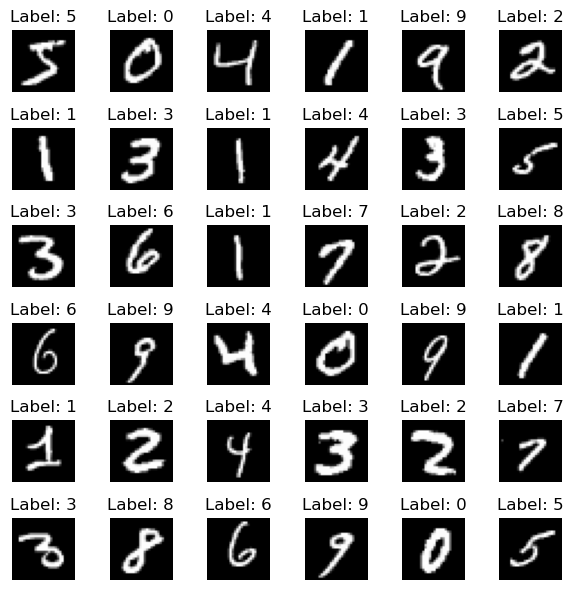

In [22]:
# Display sample images in a 4x4 grid
num_rows = 6
num_cols = 6
num_samples = num_rows * num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(6, 6))

for i in range(num_samples):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].imshow(X_train[i], cmap='gray')
    axes[row, col].axis('off')
    axes[row, col].set_title(f"Label: {y_train[i]}")

plt.tight_layout()
plt.show()

#### 3. Create Neural Network

In [29]:
#define model MLP
model = nn.Sequential(
    nn.Linear(784, 512),
    nn.Tanh(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)
model = model.to(DEVICE)

In [30]:
# Define loss function
loss_fn = nn.CrossEntropyLoss()

# Define optimizer
#opt = optim.Adam(model.parameters())

opt = optim.SGD(
   model.parameters(),
   lr=LEARNING_RATE,
   weight_decay=LAMBDA_L2
)

### 4. Train model

In [31]:
def train(dataloader, model, loss_fn, opt,DEVICE):
    for batch, (X,y) in enumerate(dataloader):
        X,y = X.to(DEVICE), y.to(DEVICE)
        #flatten the input data
        X = torch.flatten(X, start_dim = 1)
        #compute prediction error
        y_pred = model(X)
        loss = loss_fn(y_pred,y)
        #Update weights with backprop
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        # if batch % 100 == 0:
        #     loss_val = loss.item()
        #     current = batch * len(X)
        #     print(f"### [Batch-{batch}]-Loss : {loss:>7f} [{current:>5d}]/{size:>5d}")

In [32]:
def infer(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    model.eval()
    loss, correct = 0, 0
    num_batches = len(dataloader)
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            X = torch.flatten(X, start_dim=1)
            y_pred = model(X)
            loss += loss_fn(y_pred, y).item()
            correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size
    
    return loss, correct

In [37]:
def run(EPOCHS,model,DEVICE):
    start_t = time.time()
    
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []
    
    for epoch in range(EPOCHS):
        train_loss, train_acc = infer(train_loader, model, loss_fn)
        test_loss, test_acc = infer(test_loader, model, loss_fn)
        print(f"Epoch {epoch+1}/{EPOCHS} -- train loss: {train_loss:>.3f}, train acc: {train_acc:>.3f}, test loss: {test_loss:>.3f}, test acc: {test_acc:>.3f}")
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        
        train(train_loader, model, loss_fn, opt,DEVICE)
        
    elapsed_t = time.time() - start_t
    print(f"Running time for {EPOCHS} epochs : {elapsed_t:>.3f} secs")
    
    results = {
        'train_loss': train_losses,
        'train_acc': train_accs,
        'test_loss': test_losses,
        'test_acc': test_accs
        }
    return model,results

In [39]:
model,results = run(10,model,DEVICE)

Epoch 1/10 -- train loss: 2.310, train acc: 0.102, test loss: 2.310, test acc: 0.094
Epoch 2/10 -- train loss: 0.611, train acc: 0.847, test loss: 0.592, test acc: 0.850
Epoch 3/10 -- train loss: 0.402, train acc: 0.888, test loss: 0.384, test acc: 0.892
Epoch 4/10 -- train loss: 0.345, train acc: 0.901, test loss: 0.330, test acc: 0.904
Epoch 5/10 -- train loss: 0.316, train acc: 0.909, test loss: 0.302, test acc: 0.912
Epoch 6/10 -- train loss: 0.298, train acc: 0.914, test loss: 0.287, test acc: 0.917
Epoch 7/10 -- train loss: 0.280, train acc: 0.920, test loss: 0.271, test acc: 0.923
Epoch 8/10 -- train loss: 0.268, train acc: 0.923, test loss: 0.261, test acc: 0.924
Epoch 9/10 -- train loss: 0.258, train acc: 0.926, test loss: 0.251, test acc: 0.928
Epoch 10/10 -- train loss: 0.246, train acc: 0.929, test loss: 0.240, test acc: 0.932
 > Running time for 10 epochs : 183.261 secs


#### Visualize model inference

In [129]:
X_test = test_loader.dataset.data
y_test = test_loader.dataset.targets
X_test,y_test = X_test.to(torch.float32),y_test.to(torch.float32)
X_test,y_test = X_test.to(DEVICE),y_test.to(DEVICE) 

In [130]:
with torch.no_grad():
    X_test = torch.flatten(X_test, start_dim=1)
    y_pred = model(X_test[0:36])
    y_pred = y_pred.argmax(1)

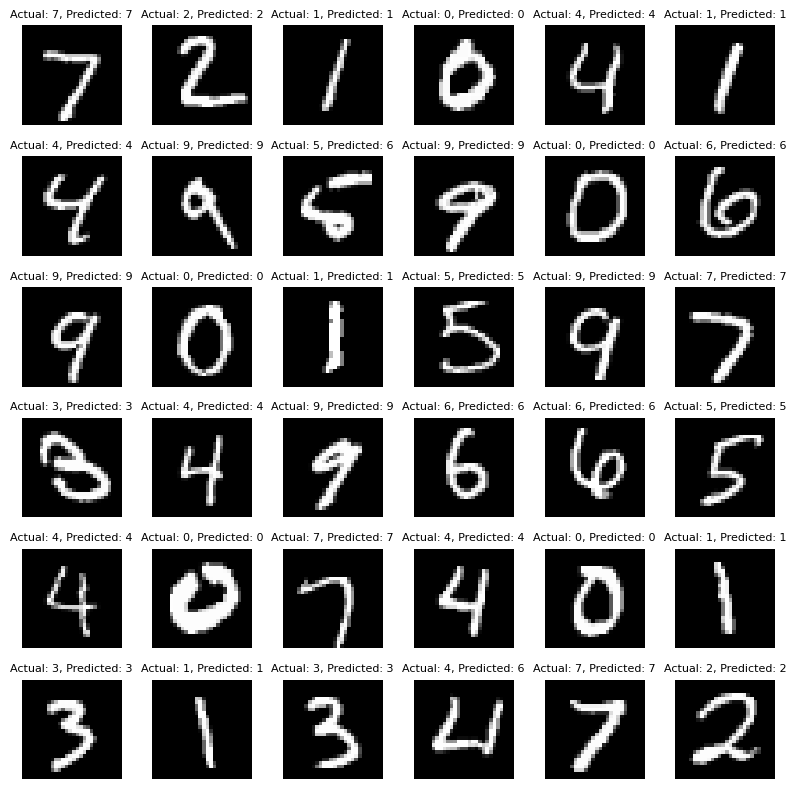

In [137]:
# Display sample images in a 4x4 grid
X_test = X_test.to('cpu')
X_test = X_test.detach().numpy()
X_test = X_test.reshape(10000,28,28)
num_rows = 6
num_cols = 6
num_samples = num_rows * num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 8))
for i in range(num_samples):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].imshow(X_test[i], cmap='gray')
    axes[row, col].axis('off')
    axes[row, col].set_title(f"Actual: {int(y_test[i])}, Predicted: {int(y_pred[i])}", fontsize = 8)
plt.tight_layout()
plt.show()